In [141]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report, r2_score, mean_squared_error, mean_squared_log_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor

In [142]:
df = pd.read_csv('data/kickstarter_projects.csv')

In [143]:
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


In [144]:
df

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed
...,...,...,...,...,...,...,...,...,...,...,...
374848,1486845240,Americas Got Talent - Serious MAK,Music,Hip-Hop,United States,2018-01-02 14:13:09,2018-01-16,500,0,0,Live
374849,974738310,EVO Planner: The World's First Personalized Fl...,Design,Product Design,United States,2018-01-02 14:15:38,2018-02-09,15000,269,8,Live
374850,2106246194,"Help save La Gattara, Arizona's first Cat Cafe!",Food,Food,United States,2018-01-02 14:17:46,2018-01-16,10000,165,3,Live
374851,1830173355,Digital Dagger Coin,Art,Art,United States,2018-01-02 14:38:17,2018-02-01,650,7,1,Live


In [145]:
def prepare_data(dataframe):
    dataframe_new = dataframe.copy()
    # extract duration
    dataframe_new["Launched"] = pd.to_datetime(dataframe_new["Launched"])
    dataframe_new["Deadline"] = pd.to_datetime(dataframe_new["Deadline"])
    dataframe_new["Duration_days"] = (dataframe_new["Deadline"] - dataframe_new["Launched"]).dt.days
    # extract month / year
    dataframe_new["Month"] = dataframe_new["Launched"].dt.month
    # drop 'State' == 'Other' (Canceled, Suspended and Live)
    dataframe_new = dataframe_new.query("State == 'Successful' or State == 'Failed'")
    # drop specific categories (?)
    # dataframe_new = dataframe_new.query("Category != '...' and Category != '...'")
    # Combine 'Category' and 'Subcategory' (to not loose correlation)
    dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
    categories = ["Category", "Subcategory", "Country", "State", "Combined_category"]
    dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
        dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]].astype("category")
    # 0 < Goal < 10_000_000
    dataframe_new = dataframe_new.query("0 < Goal < 100_000")
    # Pledged > 0
    dataframe_new = dataframe_new.query("Pledged > 0")
    # implement Name: len
    dataframe_new["Name_length"] = dataframe_new["Name"].str.len()
    # concentrate on specific region (?)
    # dataframe_new = dataframe_new.query("Country != 'United States'")

    # Years: 2012 - 2018
    dataframe_new = dataframe_new[dataframe_new["Launched"].dt.year >= 2012]
    
    dataframe_new = dataframe_new.drop(["ID", "Launched", "Deadline", "Category", "Subcategory"], axis=1)
    
    return dataframe_new

In [146]:
df.Country.unique()

array(['United States', 'United Kingdom', 'Canada', 'Australia',
       'New Zealand', 'Netherlands ', 'Sweden', 'Denmark', 'Norway',
       'Ireland', 'Germany', 'France', 'Spain', 'Belgium', 'Italy',
       'Switzerland', 'Austria', 'Luxembourg', 'Singapore', 'Hong Kong',
       'Mexico', 'Japan'], dtype=object)

In [147]:
ks = prepare_data(df)

/var/folders/y_/nw3fqlzd7yb1yprh75g9wpkw0000gn/T/ipykernel_30878/2129711282.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
/var/folders/y_/nw3fqlzd7yb1yprh75g9wpkw0000gn/T/ipykernel_30878/2129711282.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
/var/folders/y_/nw3fqlzd7yb1yprh75g9wpkw0000gn/T/ipykernel_30878/2129711282.py:23: Set

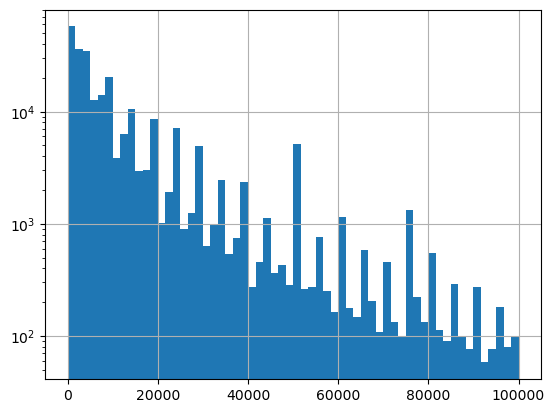

In [148]:
ks["Goal"].hist(bins=60)
plt.yscale('log')

In [149]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251831 entries, 38084 to 374605
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Name               251831 non-null  object  
 1   Country            251831 non-null  category
 2   Goal               251831 non-null  int64   
 3   Pledged            251831 non-null  int64   
 4   Backers            251831 non-null  int64   
 5   State              251831 non-null  category
 6   Duration_days      251831 non-null  int64   
 7   Month              251831 non-null  int32   
 8   Combined_category  251831 non-null  category
 9   Name_length        251831 non-null  int64   
dtypes: category(3), int32(1), int64(5), object(1)
memory usage: 15.4+ MB


In [150]:
other = df.query("State != 'Successful' and State != 'Failed'")

In [151]:
other.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
8,1502297238,Produce a Play (Canceled),Theater,Theater,United States,2009-04-29 04:37:37,2009-06-01,500,0,0,Canceled
23,194810285,Help me prototype an LED light for the Kindle ...,Technology,Software,United States,2009-05-02 20:24:08,2009-07-31,200,0,0,Canceled
27,888658718,samcclure.com - a wine and food blog (Canceled),Food,Food,United States,2009-05-04 22:49:04,2009-05-31,2000,350,2,Canceled
31,1317972662,Farmlands an Indie Game Project (Canceled),Games,Video Games,United States,2009-05-05 10:58:19,2009-08-01,10000,850,19,Canceled
33,505615987,"Book and Database of Corrupt, Crooked, and Cri...",Publishing,Nonfiction,United States,2009-05-06 09:03:57,2009-08-04,1500,50,1,Canceled


In [152]:
other.shape
# CHECK IF WE LOOSE SOMETHING (categories, countries, etc.)
# maybe get the difference between 'Goal' and 'Pledged' 

(43391, 11)

# Baseline Model

In [153]:
ks.head()

,Name,Country,Goal,Pledged,Backers,State,Duration_days,Month,Combined_category,Name_length
38084,Introspective,United States,4000,5116,37,Successful,15,1,Art - Art,13
38085,Student Doc about attending Sundance Film Fest...,United States,300,367,13,Successful,13,1,Film & Video - Documentary,50
38087,BOARDED project,United States,2345,3251,65,Successful,44,1,Art - Art,15
38088,THE CITY TROLL: a graphic novel,United States,2000,6311,202,Successful,37,1,Comics - Comics,31
38089,California Brewing Company: Bringing jobs & be...,United States,48000,1931,19,Failed,44,1,Food - Food,60


In [154]:
list(ks.columns)

['Name',
 'Country',
 'Goal',
 'Pledged',
 'Backers',
 'State',
 'Duration_days',
 'Month',
 'Combined_category',
 'Name_length']

In [155]:
X = ks[[
    'Name_length',
    'Country',
    'Combined_category', 
    'Goal', 
    #'Pledged',
    'Backers',
    'State',
    'Month',
    'Duration_days'
    ]]
y = ks['Pledged']



In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [157]:
dummy_regressor = DummyRegressor(strategy='quantile', quantile=0.21)
dummy_regressor.fit(X_train, y_train)
dr_pred = dummy_regressor.predict(X_test)

dummy_regressor.score(X_test, y_test)

-0.013872643909064397

In [158]:
r2_score(y_test, dr_pred)

-0.013872643909064397

In [159]:
mean_goal = ks['Goal'].mean()
print(mean_goal)

11580.93220850491


In [160]:
mean_pledged = ks['Pledged'].mean()
print(mean_pledged)

9686.78394240582


In [161]:
factor = mean_pledged / mean_goal
print(factor)

0.8364425046277322


#### FINAL Baseline Model

"Prediction = Goal_value * factor"

-> compute it

In [162]:
def calculate_factor(dataframe):
    # Calculate the mean of 'Goal' and 'Pledged' columns
    mean_goal = dataframe['Goal'].mean()
    mean_pledged = dataframe['Pledged'].mean()
    
    # Calculate the factor
    factor = mean_pledged / mean_goal
    
    return factor

# Example usage with a dataframe named 'ks'
factor = calculate_factor(ks)
print(factor)


0.8364425046277322


In [163]:
ks.shape

(251831, 10)

# Pipeline

### INSIGHTS:

- ~ 375.000 kickstarter projects  
- data from 2009 - 2018
- no missing values 
- no duplicates
- State = Current condition the project is in (as of 2018-01-02)
- State = Failed, Successful, Canceled, Suspended or Live 
- Peak in 2012 - 2014 (check)
- Outliers (deal with them in pipelines)
- 15 Categories for kickstarter projects (film&video, music = most frequent)
- country imbalance (~78% of data from US, ~9% from UK, 4% Canada, 2% Australia, ~1% Germany, Rest < 1 %)
- data from 2009 - 2011 only from US
- high difference between goal and pledged in between categories
- duration between 1 and 90 days
- 53% failed, 36% successful and 12% other (Canceled 10%, Live 0.7%, Suspended 0.5%)
- success rate varies for countries and categories
- two cases that pledged less than their goal but still were successful
- four cases that pledged more than their goal but still failed

    -> usually if pledged > goal = success <br>
    -> Target: 'Pledged' <br>
    -> Business case: 'Predict the expected amount of money that will be raised for a (future) project idea.' <br>
    -> Train data (input for predictions): without Nr. of Backers, Pledged, ID, State. (and Name?) <br>

<br>

### RESEACH QUESTIONS:

1. Is the success of a campaign depending on the country?
2. Is the success of a campaign depending on the category?
3. Is the success of a campaign depending on the month of launching?
4. Is the success of a campaign depending on the duration of the campaign?
5. Is the success of a campaign depending on the Name?

<br>

### HYPOTHESIS:

1. If started in US, then more money is raised.
2. If category is technology, then the campaign is more likely to succeed.
3. If the campaign is launched in September, the success rate is higher.
4. If you set your duration lower than 30 days (default) than your success rate improves.
5. The catchier and shorter the name, the higher the success rate.

<br>

### QUESTIONS:

- Do we integrate name features?
- how do we deal with other (canceled, etc.) - drop / partially drop / keep ...
- what is our base model? do we need one?
- do we deal with outliers? (goal > x million dollars) -> KEEP THEM (for learning fake campaigns also)

<br>
<br>
    
### DATA CLEANING / PREPARATION:

- drop:
    - dropped ID, Name, Launched and Deadline.

- convert:
    - converted Launched and Deadline into Duration_days  <br>
    (to loose connection to specific year in order to make more precise predictions from future (2023) campaigns)
    - converted Category and Subcategory into Combined_categories <br>
    (to not loose connection between them)

<br>


### PIPELINES:

#### PIPELINE 01 - Linear Regression

- convert into categories (OHE):
    - Country
    - Combined_category

<br>

- bins:
    - none

<br>

- polynomial feature expanision:
    - all numerical data (Goal, Duration_days, Backers)

<br>


- Scaling:
    - Goal: 1. log, 2. StandardScaler
    - Pledged: 1. log, 2. StandardScaler (?)
    - Duration_days: StandardScaler (?)

<br>

- missing values:
    - none

<br>

- additional drops (remainder):
    - State
    - Backers

In [164]:
ks.head()

,Name,Country,Goal,Pledged,Backers,State,Duration_days,Month,Combined_category,Name_length
38084,Introspective,United States,4000,5116,37,Successful,15,1,Art - Art,13
38085,Student Doc about attending Sundance Film Fest...,United States,300,367,13,Successful,13,1,Film & Video - Documentary,50
38087,BOARDED project,United States,2345,3251,65,Successful,44,1,Art - Art,15
38088,THE CITY TROLL: a graphic novel,United States,2000,6311,202,Successful,37,1,Comics - Comics,31
38089,California Brewing Company: Bringing jobs & be...,United States,48000,1931,19,Failed,44,1,Food - Food,60


In [165]:
X_test.head()

,Name_length,Country,Combined_category,Goal,Backers,State,Month,Duration_days
51437,26,United States,Music - Rock,3000,11,Failed,4,37
57757,38,United States,Film & Video - Webseries,2000,32,Successful,6,14
348934,12,United States,Fashion - Fashion,300,7,Failed,6,35
193634,30,Australia,Food - Food,676,3,Failed,1,17
112456,44,United States,Art - Illustration,870,32,Successful,9,29


In [166]:
ct_dt = ColumnTransformer([('ohe', OneHotEncoder(), ['Country', 'Combined_category', 'State', 'Month']),
                                         # ('bin', KBinsDiscretizer(), ['Family']),
                                         # ('goal', FunctionTransformer(log_transform), ['Goal']),
                                         # ('goal', pipeline_goal, ['Goal']),
                                         # ('pledged', pipeline_pledged, ['Pledged']),                                         
                                         # ('standard', MinMaxScaler(), ['Duration_days']),
                                         ], remainder='passthrough') #passtrough?

# remainder = everything not mentioned in the ColumnTransformer 
# `drop` = don't use them, `passthrough` - use them as they areX_train

In [167]:
pipeline_dt = Pipeline([
    ('preprocessor', ct_dt),
    ('regressor', DecisionTreeRegressor(max_depth=30))
])

pipeline_dt.fit(X_train, y_train)

y_pred_dt = pipeline_dt.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
print(f'Root Mean Squared Error: {mse_dt}')

r2_dt = r2_score(y_test, y_pred_dt)
print(f'R2 Score for DT Model = {r2_dt}')


Root Mean Squared Error: 61474.45281506396
R2 Score for DT Model = 0.44787979253329757


In [168]:
pipeline_dt.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['Country',
                                                   'Combined_category', 'State',
                                                   'Month'])])),
                ('regressor', DecisionTreeRegressor(max_depth=30))])>

Cross_validation and Grid Search

In [169]:
cross_val_score(pipeline_dt, X_train, y_train, n_jobs=-1, cv=10)

array([0.49251724, 0.01511623, 0.4785918 , 0.0113201 , 0.5349448 ,
       0.46619115, 0.37690075, 0.63261562, 0.07411654, 0.35038978])

In [170]:
pipeline_dt.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe', OneHotEncoder(),
                                    ['Country', 'Combined_category', 'State',
                                     'Month'])])),
  ('regressor', DecisionTreeRegressor(max_depth=30))],
 'verbose': False,
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe', OneHotEncoder(),
                                  ['Country', 'Combined_category', 'State',
                                   'Month'])]),
 'regressor': DecisionTreeRegressor(max_depth=30),
 'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'passthrough',
 'preprocessor__sparse_threshold': 0.3,
 'preprocessor__transformer_weights': None,
 'preprocessor__transformers': [('ohe',
   OneHotEncoder(),
   ['Country', 'Combined_category', 'State', 'Month'])],
 'preprocessor__verbose': False,
 'preprocessor__verbose_feature_names_out': T

In [171]:
params_dict = {'ct__age__age_bin__n_bins': [3, 5, 8],
              'model__n_neighbors': [5, 10]}

In [172]:
gridsearch = GridSearchCV(pipeline_dt, params_dict, cv=5, n_jobs=-1)

In [173]:
ks.shape

(251831, 10)

(This is our baseline model)

1. regression first, then classification
2. more features, more easier question
3. train it on subset of data -> better result
4. first classification (success or failure) and for some subset -> actual number
5. expose funding, future problems (for whom are we doing the project?)
6. new kind of staff pick (without human bias) - what will be trending/successful? (but would be missed because of manual selection process)
7. "AI / ML pick" - less risk, etc.

SUBSET IDEAS:
- drop outliers
- 2014 - 2018
- concentrate on US
- concentrate on category
- duration
- combine ideas

In [174]:
ks.describe()

,Goal,Pledged,Backers,Duration_days,Month,Name_length
count,251831.000000,2.518310e+05,251831.000000,251831.000000,251831.000000,251831.000000
mean,11580.932209,9.686784e+03,122.174276,31.607193,6.310339,34.468862
std,15774.421676,6.958468e+04,828.326125,10.956577,3.306440,15.760413
min,1.000000,1.000000e+00,0.000000,0.000000,1.000000,1.000000
25%,2000.000000,1.450000e+02,4.000000,29.000000,3.000000,21.000000
50%,5000.000000,1.221000e+03,22.000000,29.000000,6.000000,34.000000
75%,15000.000000,5.644000e+03,78.000000,33.000000,9.000000,49.000000
max,99999.000000,1.328523e+07,219382.000000,89.000000,12.000000,71.000000


In [175]:
# # Create a pipeline that applies preprocessing and then the regression model
# pipeline_random_forest = Pipeline([
#     ('preprocessor', ct_dt),
#     ('regressor', RandomForestRegressor(max_depth=30, n_jobs=-1, n_estimators=100))
# ])

# # Fit the pipeline_lin_reg to the training data
# pipeline_random_forest.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred_rf = pipeline_random_forest.predict(X_test)

# # Evaluate the model (you can use different regression metrics)
# mse_rf = mean_squared_error(y_test, y_pred_lr, squared=False)
# print(f'Root Mean Squared Error: {mse_rf}')

# r2_rf = r2_score(y_test, y_pred_lr)
# print(f'R2 Score for LR Model = {r2_rf}')

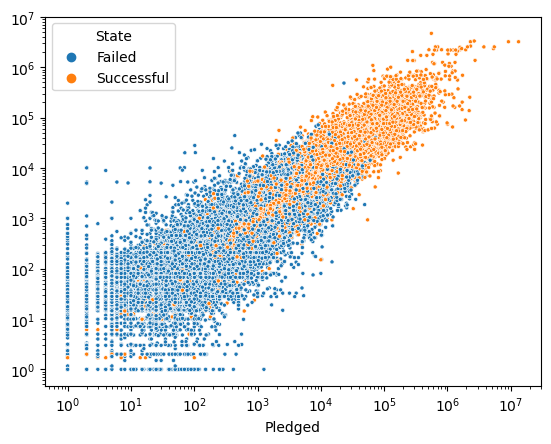

In [176]:
sns.scatterplot(x=y_test, y=y_pred_dt, hue=X_test['State'], marker='.')
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='Pledged'>

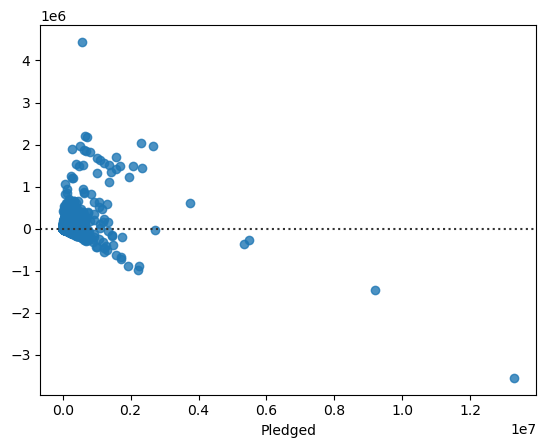

In [177]:
sns.residplot(x=y_test, y=y_pred_dt)

### SUBSET 01

In [178]:
ss_01 = df.query("Category == 'Music'")

In [179]:
ss = prepare_data(ss_01)

/var/folders/y_/nw3fqlzd7yb1yprh75g9wpkw0000gn/T/ipykernel_30878/2129711282.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
/var/folders/y_/nw3fqlzd7yb1yprh75g9wpkw0000gn/T/ipykernel_30878/2129711282.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
/var/folders/y_/nw3fqlzd7yb1yprh75g9wpkw0000gn/T/ipykernel_30878/2129711282.py:23: Set

In [180]:
X_ss = ss.drop('Pledged', axis=1)
y_ss = ss['Pledged']

In [181]:
X_ss

,Name,Country,Goal,Backers,State,Duration_days,Month,Combined_category,Name_length
38090,Before Their Eyes Music Video,United States,3000,105,Successful,20,1,Music - Rock,29
38096,Come What May's First Full-Length Record,United States,2000,61,Successful,59,1,Music - Music,40
38098,blood&stuff needs you help to release debut album,United States,2000,73,Successful,29,1,Music - Rock,49
38103,Help A Rapper Wrap It Up,United States,3000,61,Successful,20,1,Music - World Music,24
38105,"The Only Sons ""When The New Wears Off"" Album F...",United States,1500,54,Successful,24,1,Music - Rock,60
...,...,...,...,...,...,...,...,...,...
373434,Fancy Pants McGee to Spotify/iTunes (other dig...,United States,500,7,Successful,6,12,Music - Faith,59
373475,The Augie Haas Trio—Album Debut,United States,10000,3,Failed,17,12,Music - Music,31
373574,CASH ONLY- Live Show Double Album,United States,1650,20,Failed,17,12,Music - Country & Folk,33
374050,Aaron Turner Comfort Project,United States,186,17,Successful,6,12,Music - Metal,28


In [182]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y_ss, random_state=0, test_size=0.3)

In [183]:
X_train_ss.columns

Index(['Name', 'Country', 'Goal', 'Backers', 'State', 'Duration_days', 'Month',
       'Combined_category', 'Name_length'],
      dtype='object')

In [184]:
pipeline_dt = Pipeline([
    ('preprocessor', ct_dt),
    ('regressor', DecisionTreeRegressor(max_depth=30))
])

pipeline_dt.fit(X_train_ss, y_train_ss)

y_pred_dt_ss = pipeline_dt.predict(X_test_ss)

mse_dt = mean_squared_error(y_test_ss, y_pred_dt_ss, squared=False)
print(f'Root Mean Squared Error: {mse_dt}')

r2_dt = r2_score(y_test_ss, y_pred_dt_ss)
print(f'R2 Score for DT Model = {r2_dt}')

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

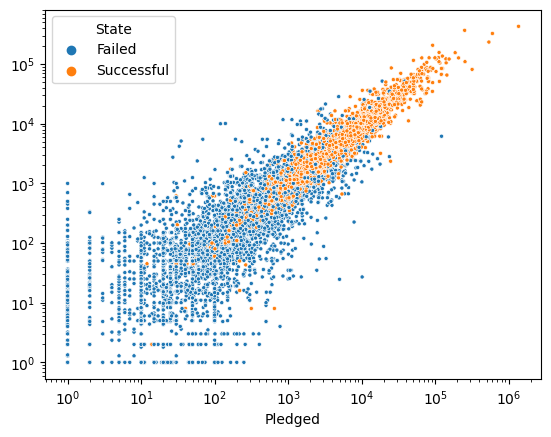

In [ ]:
sns.scatterplot(x=y_test_ss, y=y_pred_dt_ss, hue=X_test_ss['State'], marker='.')
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='Pledged'>

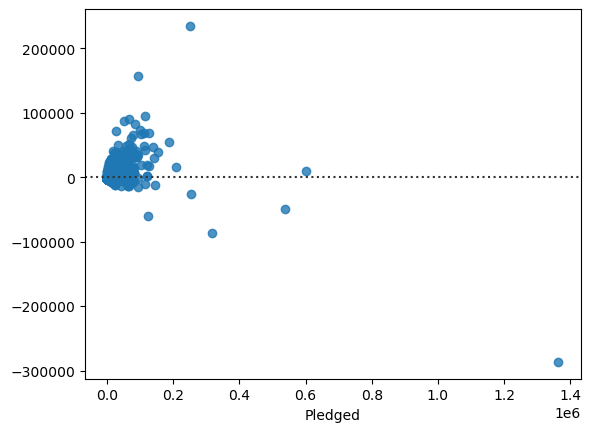

In [ ]:
sns.residplot(x=y_test_ss, y=y_pred_dt_ss)

In [ ]:
ss[ss['Pledged'] > 1000000]

,Country,Goal,Pledged,Backers,State,Duration_days,Month,Combined_category,Name_length
52085,United States,100000,1192793,24883,Successful,31,4,Music - Music,49
308353,United States,198000,1363037,10768,Successful,29,9,Music - World Music,47


IDEAS:
- stacking: use results from different categories for combined model (ask Nils)
- gridsearch / cv
- evaluation possibilites (https://dataoutpost.wordpress.com/2018/04/06/model-evaluation-of-decision-tree-regression-model/)
- residuals

## Subset 02

In [ ]:
ss_02 = df.query("Category == 'Theater'")
# Music:        69% & RMSE 9083
# Technology:   32% & RMSE 116000
# Comics:       71% & RMSE 8641 
# Dance:        91% & RMSE 1670
# Fashion:      70% & RMSE 15792
# Film & Video  77& & RMSE 11024

ss_tech = prepare_data(ss_02)

X_ss_tech = ss_tech.drop('Pledged', axis=1)
y_ss_tech = ss_tech['Pledged']

X_train_ss_tech, X_test_ss_tech, y_train_ss_tech, y_test_ss_tech = train_test_split(X_ss_tech, y_ss_tech, random_state=0, test_size=0.3)

pipeline_dt_tech = Pipeline([
    ('preprocessor', ct_dt),
    ('regressor', DecisionTreeRegressor(max_depth=30))
])

pipeline_dt_tech.fit(X_train_ss_tech, y_train_ss_tech)

y_pred_dt_ss_tech = pipeline_dt_tech.predict(X_test_ss_tech)

mse_dt_tech = mean_squared_error(y_test_ss_tech, y_pred_dt_ss_tech, squared=False)
print(f'Root Mean Squared Error: {mse_dt_tech}')

r2_dt_tech = r2_score(y_test_ss_tech, y_pred_dt_ss_tech)
print(f'R2 Score for DT Model = {r2_dt_tech}')



Root Mean Squared Error: 3687.3680134995693
R2 Score for DT Model = 0.8417142054989938


/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_23804/3108564337.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_23804/3108564337.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_23804/3108564337.py:23: Set

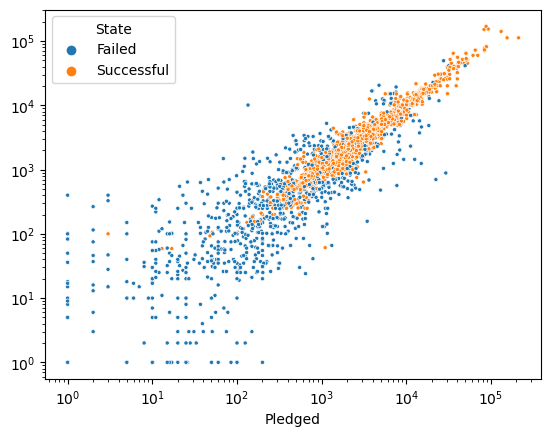

In [ ]:
sns.scatterplot(x=y_test_ss_tech, y=y_pred_dt_ss_tech, hue=X_test_ss_tech['State'], marker='.')
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='Pledged'>

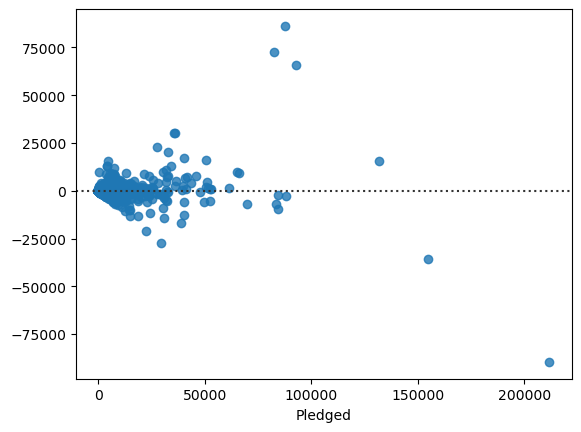

In [ ]:
sns.residplot(x=y_test_ss_tech, y=y_pred_dt_ss_tech)

# Final Subset


1. filter data => without:
   1. Goal = 0 and Goal > 10.000.000
   2. Pledged = 0 (is the same as backers = 0)
2. Get rid of poor performing categories (as our model won't apply on these)
3. Maybes:
   1. Focus on specific region like US
   2. Year (get rid of early years)



## Checklist for final Subset

1. number of rows
2. baseline function (difference between goal and pledged)
3. create our model
   1. implement Name as feature
4. improving model

In [ ]:
# Filter Data

ks


,Country,Goal,Pledged,Backers,State,Duration_days,Month,Combined_category,Name_length
0,United States,1000,625,30,Failed,39,4,Fashion - Fashion,59
1,United States,80000,22,3,Failed,87,4,Film & Video - Shorts,30
2,United States,20,35,3,Successful,8,4,Art - Illustration,19
3,United States,99,145,25,Successful,79,4,Technology - Software,28
4,United States,1900,387,10,Failed,28,4,Fashion - Fashion,10
...,...,...,...,...,...,...,...,...,...
374310,Austria,36,270,36,Successful,2,12,Games - Games,20
374400,United Kingdom,271,545,25,Successful,4,12,Games - Tabletop Games,48
374458,United States,200,202,6,Successful,3,12,Fashion - Apparel,20
374530,United States,250,265,7,Successful,1,12,Games - Tabletop Games,14
